# Tutorial

This notebook contains the tutorial to use nearest-neighbors models developed in **macchiato**.

We will first import all the libraries that will be used along the following analysis.

In [1]:
import matplotlib.pyplot as plt
import MDAnalysis as mda
import numpy as np

import macchiato

/home/ffernandez/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


To perform the analysis we need trajectories of the LiSi system. In this case we will download the data from this [repo](https://github.com/fernandezfran/unveiled_LiSi_amorphous_structures).

In [2]:
!git clone https://github.com/fernandezfran/unveiled_LiSi_amorphous_structures.git

Cloning into 'unveiled_LiSi_amorphous_structures'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 24 (delta 8), reused 24 (delta 8), pack-reused 0
Receiving objects: 100% (24/24), 5.10 MiB | 643.00 KiB/s, done.
Resolving deltas: 100% (8/8), done.


In [3]:
!ls unveiled_LiSi_amorphous_structures/

LICENSE  README.md  structures


In [4]:
!ls unveiled_LiSi_amorphous_structures/structures/

Li128Si64.out  Li160Si64.out  Li240Si64.out  Li57Si64.out
Li128Si64.xyz  Li160Si64.xyz  Li240Si64.xyz  Li57Si64.xyz
Li13Si64.out   Li210Si64.out  Li36Si64.out   Li96Si64.out
Li13Si64.xyz   Li210Si64.xyz  Li36Si64.xyz   Li96Si64.xyz


In this path we have trajectories in xyz format and outputs with thermodynamic information and with the defined box. To read the xyz files we will use [MDAnalysis](https://www.mdanalysis.org/) and for the out files we will only search for the box dimensions with the following function.

In [5]:
def get_boxes(md_out):
    with open(md_out, "r") as f:
        lines = f.readlines()
    
    boxes = []
    for i, line in enumerate(lines):
        if "Lattice" in line:
            lattice = [list(map(float, lines[i + j + 1].split())) for j in range(3)]
            boxes.append(
                np.array([lattice[0][0], lattice[1][1], lattice[2][2], 90, 90, 90])
            )
            
    return np.array(boxes, dtype=object)

We will also define the path to the files and the numbers of lithium and silicon atoms

In [6]:
path = "unveiled_LiSi_amorphous_structures/structures/"
nli = [13, 36, 57, 96, 128, 160, 210, 240]
nsi = 64
xs = np.array(nli) / nsi

Now we can read each alloy as a Universe of MDAnalysis

In [7]:
universes = []
for n in nli:
    alloy = f"Li{n}Si{nsi}"
    u = mda.Universe(path + alloy + ".xyz")
    
    boxes = get_boxes(path + alloy + ".out")
    
    for box, ts in zip(boxes, u.trajectory):
        u.dimensions = box
    
    universes.append(u)

## Chemical Shift Spectra

The following model is inferred from the behavior of the Chemical Shift Spectra in the crystalline alloys, which are used to test the package. The total spectra for each alloy comes from a contribution of each Li atom where its shift depends of the types of the Si nearest-neighbour, a contribution appears at 18 ppm when the Si atom is bonded to another Si atom and this contribution appears at 6 ppm if the Si atom is isolated. For more details, the reader is reffered to [our paper].

In [8]:
ppm = np.arange(40, -40, -0.1)
intensities = []
for x, u in zip(xs, universes):
    # center of each Li atom
    csc = macchiato.experiments.chemical_shift.ChemicalShiftCenters(u)
    csc.fit(ppm)
    
    # width of the spectra
    csw = macchiato.experiments.chemical_shift.ChemicalShiftWidth(csc)
    
    # we won't fit to experimental data here, we just define the
    # attrs related to the width of the peaks
    csw._popt = 1.0, 1.0, 1.0
    intensity = csw.predict(ppm)

    intensities.append(intensity)

Now we can plot for each alloy the intensity versus the ppm.

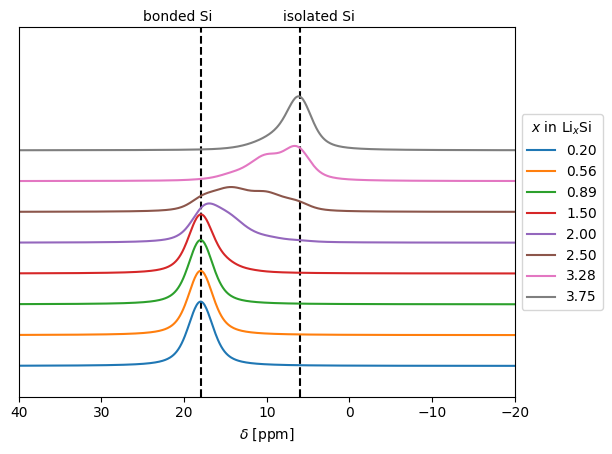

In [9]:
fig, ax = plt.subplots()

ax.vlines(18.0, -0.1, 1.1, color="k", linestyles="dashed")
ax.text(25, 1.12, "bonded Si")
ax.vlines(6.0, -0.1, 1.1, color="k", linestyles="dashed")
ax.text(8, 1.12, "isolated Si")

for i, (x, intensity) in enumerate(zip(xs, intensities)):
    ax.plot(ppm, intensity + 0.1 * i, label=f"{x:.2f}")

ax.set_xlabel(r"$\delta$ [ppm]")
ax.set_xlim((40, -20))
ax.set_ylim((-0.1, 1.1))
ax.set_yticks([])
ax.legend(title=r"$x$ in Li$_x$Si", loc="center left", bbox_to_anchor=(1, 0.5))

We see the shift in the spectra due to the breaking of Si-Si bonds as Li concentration increase, as is observed in experiments. For more details and contrast with experiments, read [our paper].

## Mössbauer Spectroscopy

Instead of full Mössbauer spectra, we are interested in the splitting that appears for different alloys due to quadrupole interaction.

In [10]:
means = []
for u in universes:
    me = macchiato.experiments.mossbauer.MossbauerEffect(u)
    means.append(np.mean(me.fit_predict(None)))

We can plot this splitting inferred from the experiment

Text(0, 0.5, '$\\Delta$ in Mössbauer peaks (mm/s)')

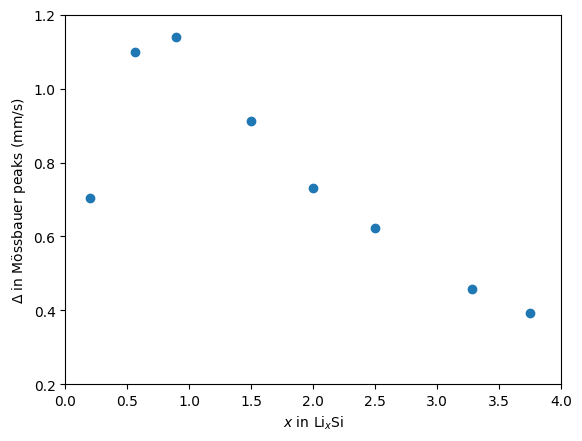

In [11]:
fig, ax = plt.subplots()

ax.scatter(xs, means)

ax.set_xlim((0, 4))
ax.set_ylim((0.2, 1.2))

ax.set_xlabel(r"$x$ in Li$_x$Si")
ax.set_ylabel(r"$\Delta$ in Mössbauer peaks (mm/s)")

This reproduce the experimental behavior and is presented in [our paper].